<a href="https://colab.research.google.com/github/KartikayBhardwaj-dev/Ai_lab/blob/main/ai_lab_Week02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STRUCTURED APPROACH TO A ML PROJECT, using roc_auc_SCORE as main

In [1]:
# @title Import necessary libaries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix



In [2]:
# @title Read and split data  set
sample_submission = pd.read_csv('/content/sample_submission.csv')
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [3]:
# @title Explore data
print('Train data and shape \n')
print(train.info(),train.shape)
print('\n Test data and shape \n')
print(test.info(),test.shape)
train.isna().sum()

Train data and shape 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float

,0
id,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0


Target variable ratios: 
 loan_status
0    50295
1     8350
Name: count, dtype: int64 
50295 users not approved loan while 8350 approved 



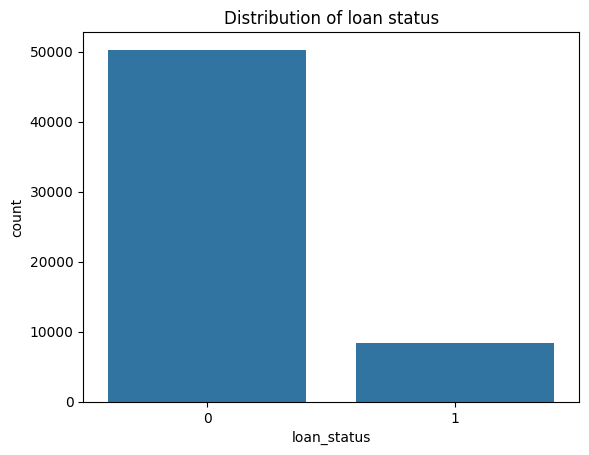

In [4]:
# @title EDA of target variable
print(f'Target variable ratios: \n {train['loan_status'].value_counts()} ')
print('50295 users not approved loan while 8350 approved \n')
sns.countplot(data=train, x='loan_status')
plt.title('Distribution of loan status')
plt.show()

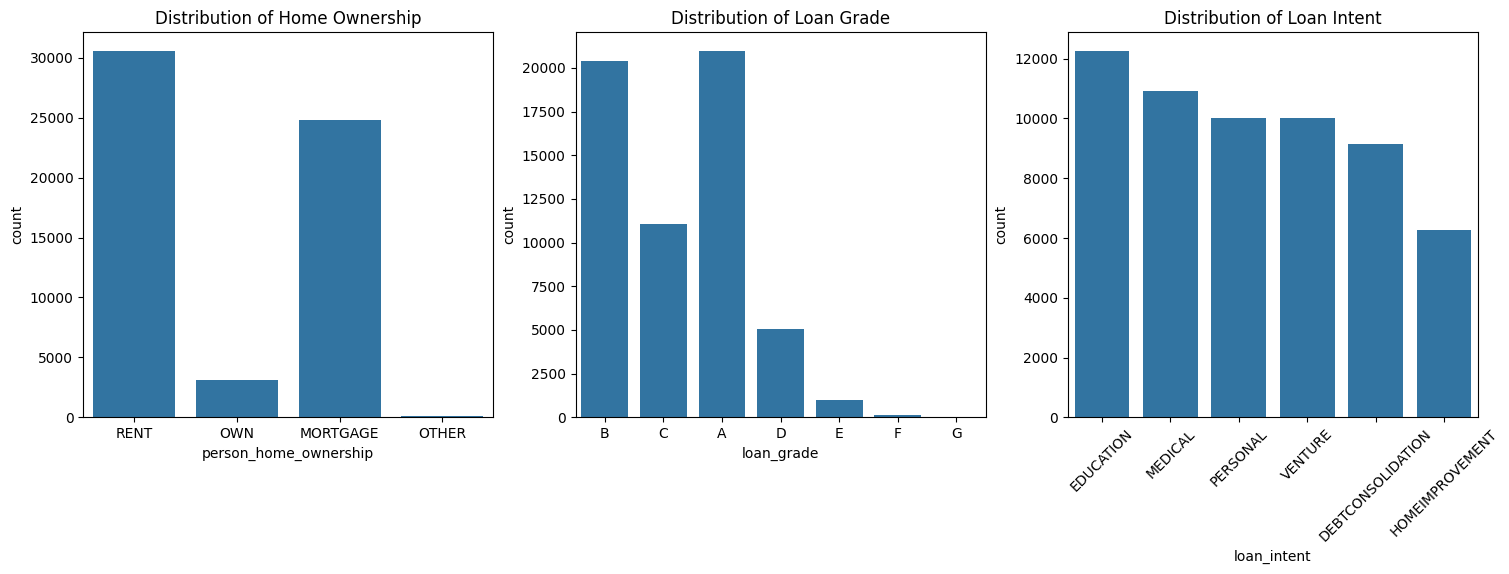

<Figure size 640x480 with 0 Axes>

In [5]:
# @title Univariate Feature analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(data=train, x='person_home_ownership', ax=axes[0])
axes[0].set_title('Distribution of Home Ownership')

sns.countplot(data=train, x="loan_grade", ax=axes[1])
axes[1].set_title("Distribution of Loan Grade")

sns.countplot(data=train, x="loan_intent", ax=axes[2])
axes[2].set_title("Distribution of Loan Intent")
plt.xticks(rotation=45)
plt.show()

plt.tight_layout()
plt.show()

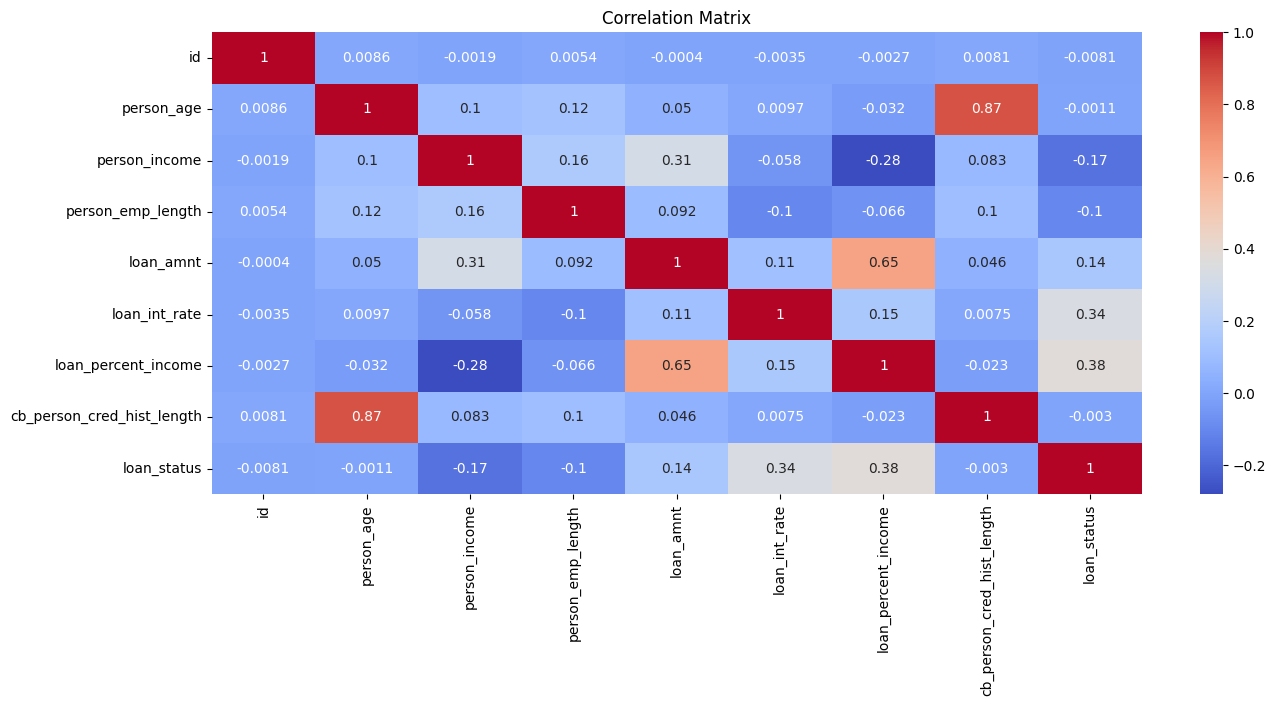

In [9]:
# @title bivariate analysis
plt.figure(figsize=(15, 6))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [6]:
# @title Creating a Validation dataset: we use this because to replace test set, but if we use same validation set repeteldly we can lead to overfit model
train = train.drop(columns=["id"])
test = test.drop(columns=["id"])
X = train.iloc[ :, :-1]
y = train.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# @title Feature Engineering


In [8]:
# @title PreProcessing
ordinal_cols = ["loan_grade"]
onehot_cols = ["person_home_ownership", "loan_intent", "cb_person_default_on_file"]

ordinal_transformer = OrdinalEncoder(categories=[['C', 'D', 'B', 'A', 'F', 'E', 'G']])
oneHot_transformer = OneHotEncoder(handle_unknown="ignore")

preproccesor = ColumnTransformer(
    transformers=[
        ("ord", ordinal_transformer, ordinal_cols),
        ("ohe", oneHot_transformer, onehot_cols)
    ], remainder="passthrough"
)

pipeline = Pipeline([
    ("preprocessor", preproccesor),
    ("scaler", MinMaxScaler())
])
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

test_processed = pipeline.transform(test)

print(f"The shape of the processed training data: {X_train_processed.shape}")
print(f"The shape of the processed validation data: {X_test_processed.shape}")
print(f"The shape of the processed test data: {test_processed.shape}")

The shape of the processed training data: (46916, 20)
The shape of the processed validation data: (11729, 20)
The shape of the processed test data: (39098, 20)


In [10]:
# @title Baseline model: using logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_processed, y_train)
y_pred_proba = clf.predict_proba(X_test_processed)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)*100
print(f"ROC AUC SCORE: {roc_auc}")

ROC AUC SCORE: 89.30434984489715


In [11]:
# @title explore more models

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42),
    "Bagging": BaggingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

def evaluate_models(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)

  results = {}
  for split, (X, y) in {"Train": (X_train, y_train), "Test": (X_test, y_test)}.items():
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X)
    results[split] = {
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, zero_division=0),
        "Recall": f1_score(y, y_pred, zero_division=0),
        "f1-score": f1_score(y, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y, y_proba)
    }
    return results
final_results = {}
for name, model in models.items():
  final_results[name] = evaluate_models(model, X_train_processed, y_train, X_test_processed, y_test)
results_df = pd.concat({outer: pd.DataFrame(inner).T for outer, inner in final_results.items()})
print(results_df)

                           Accuracy  Precision    Recall  f1-score   ROC-AUC
Logistic Regression Train  0.899757   0.755229  0.554345  0.554345  0.889443
Naive Bayes         Train  0.808978   0.408662  0.532547  0.532547  0.853024
Decision Tree       Train  1.000000   1.000000  1.000000  1.000000  1.000000
Random Forest       Train  0.999893   1.000000  0.999626  0.999626  1.000000
KNN                 Train  0.946266   0.907186  0.786120  0.786120  0.975763
SVM                 Train  0.926805   0.890144  0.683210  0.683210  0.902356
Bagging             Train  0.992519   0.994995  0.973151  0.973151  0.999836
AdaBoost            Train  0.921327   0.797295  0.684719  0.684719  0.912288


Initial observation

- Most of the models have a poor f1_score. This could be due to imbalance in the target. scores can be compared once imabalance handling methoids are used
- Decision Tree model has overfit on the training but performed poorly on validation. Tuning hyperparameters such as max_depth would provide more insights
- adaboost and randomforest models have performed and random forest performed comparetively good candidate for hyperparameter tuning

In [12]:
# @title HyperParameter tuning for random Forest
rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring="f1", n_jobs=-1)
rf_grid.fit(X_train_processed, y_train)
best_rf = rf_grid.best_estimator_


In [13]:
# @title hyperParameter tuning for Adaboost
ada_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1.0]
}
ada_grid = GridSearchCV(AdaBoostClassifier(random_state=42), ada_params, cv=5, scoring="f1", n_jobs=-1)
ada_grid.fit(X_train_processed, y_train)
best_ada = ada_grid.best_estimator_

In [16]:
# @title Re-Evaluation of best model
def evaluate_best_model(model, X_test, y_test):
  y_pred = model.predict(X_test)
  y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
  return {
       "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": f1_score(y_test, y_pred, zero_division=0),
        "f1-score": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
  }
print("Best Random forest Params", rf_grid.best_params_)
print("Best Random forest test performance", evaluate_best_model(best_rf, X_test_processed, y_test))
print("\n Best AdaBoost Params", ada_grid.best_params_)
print("Best AdaBoost test performance", evaluate_best_model(best_ada, X_test_processed, y_test))

Best Random forest Params {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best Random forest test performance {'Accuracy': 0.9509762128058658, 'Precision': 0.9334916864608076, 'Recall': 0.8039549948857825, 'f1-score': 0.8039549948857825, 'ROC-AUC': np.float64(0.9365449834003332)}

 Best AdaBoost Params {'learning_rate': 1.0, 'n_estimators': 200}
Best AdaBoost test performance {'Accuracy': 0.9287236763577458, 'Precision': 0.8320063694267515, 'Recall': 0.7142857142857143, 'f1-score': 0.7142857142857143, 'ROC-AUC': np.float64(0.9227275839016865)}


In [17]:
# @title XGB Classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="auc")
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_processed, y_train)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_processed)
print("Test Accuracy:", accuracy_score(y_test, y_pred))





Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:34:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Test Accuracy: 0.9514025066075539
